In [ ]:
# http://benalexkeen.com/bg-nbd-model-for-customer-base-analysis-in-python/

In [5]:
import pandas as pd
import numpy as np

df = pd.read_excel('bgnbd.xls', sheet_name='Raw Data').set_index('ID')
df.head()

,x,t_x,T
ID,,,
1,2,30.428571,38.857143
2,1,1.714286,38.857143
3,0,0.000000,38.857143
4,0,0.000000,38.857143
5,0,0.000000,38.857143


In [6]:
from scipy.special import gammaln

def negative_log_likelihood(params, x, t_x, T):
    if np.any(np.asarray(params) <= 0):
        return np.inf

    r, alpha, a, b = params

    ln_A_1 = gammaln(r + x) - gammaln(r) + r * np.log(alpha)
    ln_A_2 = (gammaln(a + b) + gammaln(b + x) - gammaln(b) -
           gammaln(a + b + x))
    ln_A_3 = -(r + x) * np.log(alpha + T)
    ln_A_4 = x.copy()
    ln_A_4[ln_A_4 > 0] = (
        np.log(a) -
        np.log(b + ln_A_4[ln_A_4 > 0] - 1) -
        (r + ln_A_4[ln_A_4 > 0]) * np.log(alpha + t_x)
    )
    
    delta =  np.where(x>0, 1, 0)
    
    log_likelihood = ln_A_1 + ln_A_2 + np.log(np.exp(ln_A_3) + delta * np.exp(ln_A_4))
    return -log_likelihood.sum()

In [8]:
from scipy.optimize import minimize

scale = 1 / df['T'].max()
scaled_recency = df['t_x'] * scale
scaled_T = df['T'] * scale

def _func_caller(params, func_args, function):
    return function(params, *func_args)

current_init_params = np.array([1.0, 1.0, 1.0, 1.0])
output = minimize(
    _func_caller,
    method="Nelder-Mead",
    tol=0.0001,
    x0=current_init_params,
    args=([df['x'], scaled_recency, scaled_T], negative_log_likelihood),
    options={'maxiter': 2000}
)

r = output.x[0]
alpha = output.x[1]
a = output.x[2]
b = output.x[3]

alpha /= scale

print("r = {}".format(r))
print("alpha = {}".format(alpha))
print("a = {}".format(a))
print("b = {}".format(b))


r = 0.24259412356864324
alpha = 4.413588131347807
a = 0.7929354716520993
b = 2.4259553697230176


In [9]:
from scipy.special import hyp2f1

def expected_sales_to_time_t(t):
    hyp2f1_a = r
    hyp2f1_b = b
    hyp2f1_c = a + b - 1
    hyp2f1_z = t / (alpha + t)
    hyp_term = hyp2f1(hyp2f1_a, hyp2f1_b, hyp2f1_c, hyp2f1_z)
    
    return ((a + b - 1) / (a - 1)) * (1-(((alpha / (alpha+t)) ** r) * hyp_term))

In [10]:
expected_sales_to_time_t(52)

1.444010643699092

In [11]:
n_s = (39 - df['T']).value_counts().sort_index()

n_s.head()

0.142857    18
0.285714    22
0.428571    17
0.571429    20
0.714286    23
Name: T, dtype: int64

In [12]:
forecast_range = np.arange(0, 78, 1/7.0)

def cumulative_repeat_transactions_to_t(t):
    expected_transactions_per_customer = (t - n_s.index).map(lambda x: expected_sales_to_time_t(x) if x > 0 else 0)
    expected_transactions_all_customers = (expected_transactions_per_customer * n_s).values
    return expected_transactions_all_customers.sum()

cum_rpt_sales = pd.Series(map(cumulative_repeat_transactions_to_t, forecast_range), index=forecast_range)

cum_rpt_sales.tail(10)

76.571429    4109.744742
76.714286    4114.856053
76.857143    4119.961614
77.000000    4125.061441
77.142857    4130.155549
77.285714    4135.243956
77.428571    4140.326675
77.571429    4145.403724
77.714286    4150.475118
77.857143    4155.540873
dtype: float64

In [13]:
def calculate_conditional_expectation(t, x, t_x, T):
    first_term = (a + b + x - 1) / (a-1)
    hyp2f1_a = r + x
    hyp2f1_b = b + x
    hyp2f1_c = a + b + x - 1
    hyp2f1_z = t / (alpha + T + t)
    hyp_term = hyp2f1(hyp2f1_a, hyp2f1_b, hyp2f1_c, hyp2f1_z)
    second_term = (1 - ((alpha + T) / (alpha + T + t)) ** (r + x) * hyp_term)
    delta = 1 if x > 0 else 0
    denominator = 1 + delta * (a / (b + x - 1)) * ((alpha + T) / (alpha + t_x)) ** (r+x)
    return first_term * second_term / denominator


calculate_conditional_expectation(39, 2, 30.43, 38.86)

1.225904664486748

In [ ]:
##############################################
Same as above using module lifetimes
##############################################

In [16]:
from lifetimes.datasets import load_cdnow_summary
data = load_cdnow_summary(index_col=[0])

print(data.head())

    frequency  recency      T
ID                           
1           2    30.43  38.86
2           1     1.71  38.86
3           0     0.00  38.86
4           0     0.00  38.86
5           0     0.00  38.86


In [17]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])



<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.77, alpha: 4.41, b: 2.32, r: 0.24>


'\n<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>\n'

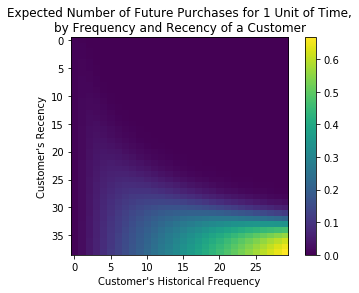

In [19]:
%matplotlib inline
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

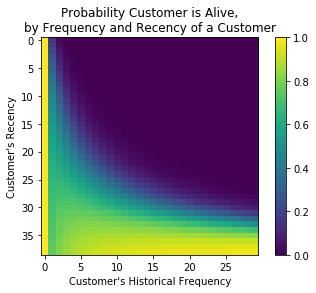

In [20]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

In [21]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,predicted_purchases
ID,,,,
509,18,35.14,35.86,0.425670
841,19,34.00,34.14,0.475448
1981,17,28.43,28.86,0.487419
157,29,37.71,38.00,0.663241
1516,26,30.86,31.00,0.711565


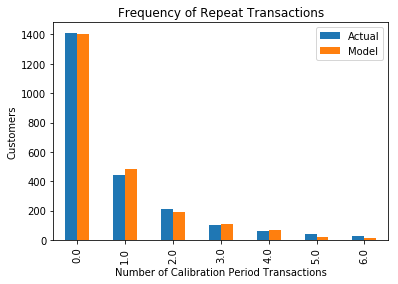

In [22]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [23]:
from lifetimes.datasets import load_transaction_data
from lifetimes.utils import summary_data_from_transaction_data

transaction_data = load_transaction_data()
print(transaction_data.head())

                  date  id
0  2014-03-08 00:00:00   0
1  2014-05-21 00:00:00   1
2  2014-03-14 00:00:00   2
3  2014-04-09 00:00:00   2
4  2014-05-21 00:00:00   2


In [24]:
summary = summary_data_from_transaction_data(transaction_data, 'id', 'date', observation_period_end='2014-12-31')

print(summary.head())

    frequency  recency      T
id                           
0         0.0      0.0  298.0
1         0.0      0.0  224.0
2         6.0    142.0  292.0
3         0.0      0.0  147.0
4         2.0      9.0  183.0


In [25]:
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 5000 subjects, a: 1.85, alpha: 1.86, b: 3.18, r: 0.16>

In [26]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'id', 'date',
                                        calibration_period_end='2014-09-01',
                                        observation_period_end='2014-12-31' )   
print(summary_cal_holdout.head())

    frequency_cal  recency_cal  T_cal  frequency_holdout  duration_holdout
id                                                                        
0             0.0          0.0  177.0                0.0               121
1             0.0          0.0  103.0                0.0               121
2             6.0        142.0  171.0                0.0               121
3             0.0          0.0   26.0                0.0               121
4             2.0          9.0   62.0                0.0               121


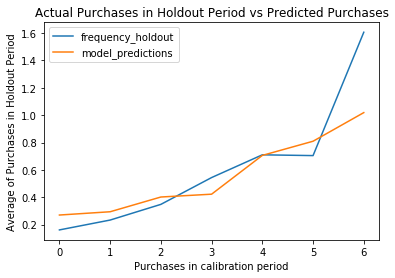

In [27]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [28]:
t = 10 #predict purchases in 10 periods
individual = summary.iloc[20]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])
# 0.0576511

0.057650853229541714

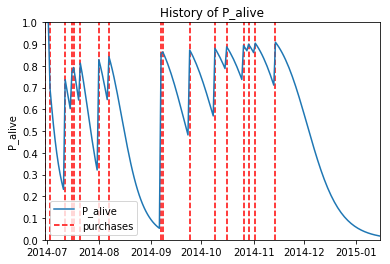

In [29]:
from lifetimes.plotting import plot_history_alive

id = 35
days_since_birth = 200
sp_trans = transaction_data.loc[transaction_data['id'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'date')

In [30]:
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value

summary_with_money_value = load_cdnow_summary_data_with_monetary_value()
summary_with_money_value.head()
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]

print(returning_customers_summary.head())

             frequency  recency      T  monetary_value
customer_id                                           
1                    2    30.43  38.86           22.35
2                    1     1.71  38.86           11.77
6                    7    29.43  38.86           73.74
7                    1     5.00  38.86           11.77
9                    2    35.71  38.86           25.55


In [31]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.113884
frequency,0.113884,1.000000


In [32]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 946 subjects, p: 6.25, q: 3.74, v: 15.45>


In [33]:
print(ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).head(10))

customer_id
1     24.658621
2     18.911492
3     35.171002
4     35.171002
5     35.171002
6     71.462846
7     18.911492
8     35.171002
9     27.282411
10    35.171002
dtype: float64


In [34]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).mean(),
    summary_with_money_value[summary_with_money_value['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 35.252958281394996, Average profit: 35.07855179704017


In [35]:
# refit the BG model to the summary_with_money_value dataset
bgf.fit(summary_with_money_value['frequency'], summary_with_money_value['recency'], summary_with_money_value['T'])

print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary_with_money_value['frequency'],
    summary_with_money_value['recency'],
    summary_with_money_value['T'],
    summary_with_money_value['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).head(10))

customer_id
1      140.095130
2       18.943332
3       38.180572
4       38.180572
5       38.180572
6     1003.856493
7       28.109475
8       38.180572
9      167.416983
10      38.180572
Name: clv, dtype: float64
